# MSSW on airlines evaluation

## Accept and preprocess the airlines dataset

In [1]:
import csv

import numpy as np
import pandas as pd
import seaborn as sb

In [21]:
from eval_helpers import accepting
from sklearn.preprocessing import OneHotEncoder


df = pd.read_csv("../Datasets_concept_drift/real_world_data/airline_dataset.csv")

X = df.drop(columns=['Unnamed: 0', 'Delay'])
y = df["Delay"]

print('number of unique airlines', df['Airline'].nunique())

X_ref = X[:179794]
X_test = X[179794:]
y_ref = y[:179794]
y_test = y[179794:]

df_x_ref_num, df_x_ref_cat = accepting.divide_numeric_categorical(X_ref)
df_x_test_num, df_x_test_cat = accepting.divide_numeric_categorical(X_test)

ref_index = df_x_ref_cat.index
test_index = df_x_test_cat.index
encoder = OneHotEncoder(sparse=False)
encoder.fit(df_x_ref_cat)
df_x_ref_cat_transformed = pd.DataFrame(encoder.transform(df_x_ref_cat))
df_x_test_cat_transformed = pd.DataFrame(encoder.transform(df_x_test_cat))
df_x_ref_cat_transformed.set_index(ref_index, inplace=True)
df_x_test_cat_transformed.set_index(test_index, inplace=True)

reference_data = df_x_ref_num.join(df_x_ref_cat_transformed, lsuffix='_num').to_numpy()
testing_data = df_x_test_num.join(df_x_test_cat_transformed, lsuffix='_num').to_numpy()

X_ref = reference_data
X_test = testing_data
y_ref = y_ref.to_numpy()
y_test = y_test.to_numpy()

print('\nreference data')
print(X_ref.shape)
# print(X_ref)
print('\nreference labels')
print(y_ref.shape)
print('\ntesting data')
print(X_test.shape)
# print(X_test)
print('\ntesting labels')
print(y_test.shape)

number of unique airlines 18

reference data
(179794, 21)

reference labels
(179794,)

testing data
(359589, 21)

testing labels
(359589,)


## Split the dataset to batches (size=17000)

In [22]:
from eval_helpers import helpers

X_test_batches_year, y_test_batches_year = helpers.split_to_fixed_size_batches(X_test, y_test, batch_size=17000)
X_ref_batches_year, y_ref_batches_year = helpers.split_to_fixed_size_batches(X_ref, y_ref, batch_size=17000)

print('# yearly test batches:')
print(len(X_test_batches_year))
print(len(y_test_batches_year))
print('# yearly ref batches:')
print(len(X_ref_batches_year))
print(len(y_ref_batches_year))

chunk size 17000
number of chunks 21
number of data 359589
shape of X that can be split perfectly (357000, 21)
number of resulting batches 21
[[6230.  671.   36. ...    0.    0.    0.]
 [6849.  671.   38. ...    0.    0.    0.]
 [6973.  671.  149. ...    0.    0.    0.]
 ...
 [1004.  815.  145. ...    0.    0.    0.]
 [1192.  815.  160. ...    0.    0.    0.]
 [1587.  815.   55. ...    0.    0.    0.]]
(17000, 21)
chunk size 17000
number of chunks 10
number of data 179794
shape of X that can be split perfectly (170000, 21)
number of resulting batches 10
[[2.690e+02 1.500e+01 2.050e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.558e+03 1.500e+01 2.220e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.400e+03 2.000e+01 1.650e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [3.323e+03 1.275e+03 1.200e+02 ... 1.000e+00 0.000e+00 0.000e+00]
 [2.192e+03 1.275e+03 8.500e+01 ... 0.000e+00 1.000e+00 0.000e+00]
 [2.976e+03 1.275e+03 1.130e+02 ... 0.000e+00 1.000e+00 0.000e+00]]
(17000, 21)
# yearly test batche

## Find suitable KMeans clustering parameters for different numbers of clusters

In [38]:
from core import mssw_preprocessing
from eval_helpers import kmeans_verbose_helpers

weighted_joined_reference_data, _, _ = mssw_preprocessing.mssw_preprocess(X_ref_batches_year, X_test_batches_year)

filename = 'weather_yearly_output.txt'
print(kmeans_verbose_helpers)
kmeans_verbose_helpers.write_verbose_kmeans_to_file(filename, weighted_joined_reference_data,
                                                    n_clusters=2, n_init=100, max_iter=500, tol=0, random_state=1053)
output_dicts = kmeans_verbose_helpers.convert_kmeans_output_file_to_dicts(filename, n_init=100)
kmeans_verbose_helpers.print_stats_from_kmeans_output_dicts(output_dicts)

<module 'eval_helpers.kmeans_verbose_helpers' from 'C:\\Users\\jpohl\\PycharmProjects\\clustering-drift-detection\\mssw\\eval_helpers\\kmeans_verbose_helpers.py'>
random state: 1053
total number of results: 100
maximum number of iterations: 11
minimum initial inertia: 1238.7292971421946
maximum initial inertia: 1689.3957389146353
number of unique final inertia values: 22
minimum final inertia: 705.9325724707849
maximum final inertia: 770.3263231407457
total number of convergences: 100
number of strict convergences: 100
number of tol-based convergences: 0


### Use the elbow method to find the best number of clusters (by inertia)

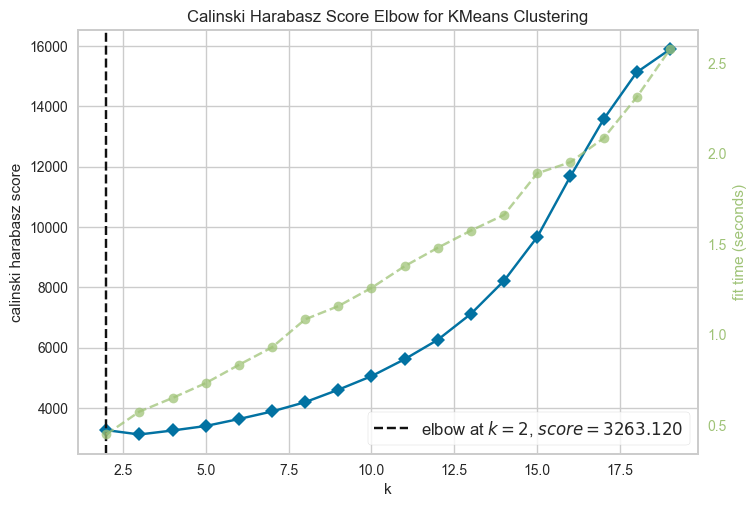

KElbowVisualizer(ax=<AxesSubplot: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>,
                 estimator=KMeans(max_iter=500, n_clusters=19, n_init=100,
                                  random_state=0, tol=0),
                 k=(2, 20), metric='calinski_harabasz')

In [46]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer


kmeans = KMeans(n_init=100, max_iter=500, tol=0, random_state=0)
kelbow_visualizer(kmeans, weighted_joined_reference_data, k=(2, 20), metric='calinski_harabasz')

# multiple_n_clusters = list(range(1, 11))
# final_inertia = []
# for n_clusters in multiple_n_clusters:
#     fitted_kmeans = KMeans(
#         n_clusters=n_clusters,
#         n_init=100,
#         max_iter=500,
#         tol=0,
#         random_state=0
#     ).fit(weighted_joined_reference_data)
#     final_inertia.append(fitted_kmeans.inertia_)
    
# print(final_inertia)
    
# plt.plot(multiple_n_clusters, final_inertia)
# plt.show()

## Yearly predictions - drift detection evaluation

### Read the defined yearly drift locations

In [6]:
import csv

true_drift_bool_year = []
with open('../Datasets_concept_drift/real_world_data_drifts/weather/weather_yearly_drifts.csv') as f:
    rdr = csv.reader(f, delimiter=',')
    for row in rdr:
        true_drift_bool_year.append(row)
    true_drift_bool_year = true_drift_bool_year[0] # only one row of important data
    true_drift_bool_year = [b == 'True' for b in true_drift_bool_year]
print(true_drift_bool_year)

[False, True, True, True, False, True, False, False, False, False, True, True, False, False, True, True, True, True, False, False, False, True, False, True, True, False, True, True, True, False, False, True, True]


### Use them for the evaluation

In [7]:
from eval_helpers import mssw_eval_real_world

_, fpr_mean, _, det_acc_mean, _ = mssw_eval_real_world.all_drifting_batches_randomness_robust(
    reference_data_batches=X_ref_batches_year,
    testing_data_batches=X_test_batches_year,
    true_drift_bool=true_drift_bool_year,
    n_clusters=2, n_init=100, max_iter=70, tol=0,
    coeff=2.66, first_random_state=0,
    min_runs=2, std_err_threshold=0.05
)

print('yearly mean FPR:', fpr_mean)
print('yearly mean detection accuracy:', det_acc_mean)

min_runs 2
centroid distance sums [[21.32771081 25.60396886]]
num points in clusters [[180. 185.]]
centroid distance sums [[26.20212723 32.15697697]]
num points in clusters [[191. 174.]]
centroid distance sums [[97.84562262 35.52029605]]
num points in clusters [[169. 196.]]
centroid distance sums [[27.70274101 32.7114962 ]]
num points in clusters [[196. 169.]]
centroid distance sums [[63.32689257 33.34692383]]
num points in clusters [[186. 179.]]
centroid distance sums [[19.25856919 28.29477777]]
num points in clusters [[173. 192.]]
centroid distance sums [[33.23625307 39.478776  ]]
num points in clusters [[190. 175.]]
centroid distance sums [[24.8389075  30.37018604]]
num points in clusters [[186. 179.]]
centroid distance sums [[25.557464  28.8377972]]
num points in clusters [[190. 175.]]
centroid distance sums [[25.00500761 33.49911266]]
num points in clusters [[181. 184.]]
centroid distance sums [[25.31448181 29.03056213]]
num points in clusters [[188. 177.]]
centroid distance sums 

## Monthly predictions - drift detection evaluation

### Read the defined monthly drift locations

In [8]:
import csv

true_drift_bool_month = []
with open('../Datasets_concept_drift/real_world_data_drifts/weather/weather_monthly_drifts.csv') as f:
    rdr = csv.reader(f, delimiter=',')
    for row in rdr:
        true_drift_bool_month.append(row)
    true_drift_bool_month = true_drift_bool_month[0] # only one row of important data
    true_drift_bool_month = [b == 'True' for b in true_drift_bool_month]
print(true_drift_bool_month)

[False, False, False, False, False, False, False, False, False, False, True, True, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, Fal

### Use them for the evaluation

In [10]:
from eval_helpers import mssw_eval_real_world

_, fpr_mean, _, det_acc_mean, _ = mssw_eval_real_world.all_drifting_batches_randomness_robust(
    reference_data_batches=X_ref_batches_month,
    testing_data_batches=X_test_batches_month,
    true_drift_bool=true_drift_bool_month,
    n_clusters=2, n_init=100, max_iter=90, tol=0,
    coeff=2.66, first_random_state=0,
    min_runs=2, std_err_threshold=0.05
)

print('yearly mean FPR:', fpr_mean)
print('yearly mean detection accuracy:', det_acc_mean)

min_runs 2
centroid distance sums [[4.18704012 1.13600062]]
num points in clusters [[25.  5.]]
centroid distance sums [[6.10203189 0.8271545 ]]
num points in clusters [[26.  4.]]
centroid distance sums [[9.80187249 0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[12.5669593  0.       ]]
num points in clusters [[30.  0.]]
centroid distance sums [[17.93137689  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[24.94819316  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[25.08486799  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[24.02899442  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[21.08014001  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[17.72597664  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[10.96473204  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[6.85898796 1.49419068]]
nu

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[4.55899623 2.08910448]]
num points in clusters [[22.  8.]]
centroid distance sums [[6.06415105 0.52966717]]
num points in clusters [[27.  3.]]
centroid distance sums [[7.95666528 0.93142212]]
num points in clusters [[27.  3.]]
centroid distance sums [[14.41213963  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[17.73183238  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[26.56548925  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[25.25167107  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[23.02005729  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[20.23677579  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[12.6021774  0.       ]]
num points in clusters [[30.  0.]]
centroid distance sums [[8.8643995  0.97213613]]
num points in clusters [[27.  3.]]
centroid distance sums [[5.69077574 0.64076453]]
num points in c

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[7.95007941 0.77830757]]
num points in clusters [[27.  3.]]
centroid distance sums [[6.75898648 1.39683153]]
num points in clusters [[25.  5.]]
centroid distance sums [[8.95655068 0.70701754]]
num points in clusters [[28.  2.]]
centroid distance sums [[11.00955761  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[10.37481092  0.29975195]]
num points in clusters [[29.  1.]]
centroid distance sums [[15.04438202  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[19.6300077  0.       ]]
num points in clusters [[30.  0.]]
centroid distance sums [[23.41538513  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[23.76492036  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[22.73304811  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[20.25231621  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[14.28928639  0.        ]]
num points 

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[26.75392324  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[24.30027745  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[19.27804639  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[11.79828471  0.29807042]]
num points in clusters [[29.  1.]]
centroid distance sums [[5.65761533 1.87506932]]
num points in clusters [[22.  8.]]
centroid distance sums [[3.2442961  5.15787468]]
num points in clusters [[13. 17.]]
centroid distance sums [[4.06377728 2.54685262]]
num points in clusters [[21.  9.]]
centroid distance sums [[6.15850183 1.10278535]]
num points in clusters [[25.  5.]]
centroid distance sums [[9.78446173 0.28735295]]
num points in clusters [[29.  1.]]
centroid distance sums [[14.61860061  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[18.73370042  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[21.97542354  0.        ]]
num points in

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[27.99561405  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[21.7998324  0.       ]]
num points in clusters [[30.  0.]]
centroid distance sums [[8.74708552 0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[ 1.06672435 10.94258587]]
num points in clusters [[ 4. 26.]]
centroid distance sums [[6.43070108 1.0112847 ]]
num points in clusters [[26.  4.]]
centroid distance sums [[6.74283469 1.51682848]]
num points in clusters [[24.  6.]]
centroid distance sums [[95.39562455  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[15.03033773  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[17.46602084  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[22.8306921  0.       ]]
num points in clusters [[30.  0.]]
centroid distance sums [[25.64478138  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[23.29646623  0.        ]]
num points in

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[22.95892938  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[26.14396547  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[24.08756407  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[22.00527949  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[17.98556148  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[14.16851274  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[10.33790848  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[5.91344188 2.94993052]]
num points in clusters [[22.  8.]]
centroid distance sums [[6.54581013 2.94312057]]
num points in clusters [[22.  8.]]
centroid distance sums [[5.31461494 2.3740171 ]]
num points in clusters [[23.  7.]]
centroid distance sums [[10.90012975  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[16.79980972  0.        ]]
num point

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[2.85706957 5.87297589]]
num points in clusters [[14. 16.]]
centroid distance sums [[5.6610968 2.8284377]]
num points in clusters [[22.  8.]]
centroid distance sums [[9.02725445 1.83807744]]
num points in clusters [[24.  6.]]
centroid distance sums [[10.17815512  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[16.70428375  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[21.44557699  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[25.73166654  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[21.55424126  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[18.2231134  0.       ]]
num points in clusters [[30.  0.]]
centroid distance sums [[13.86022453  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[9.57395934 0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[6.77784096 1.23068828]]
num points in clu

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[24.92136486  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[18.61888841  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[16.18196527  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[10.45286609  0.27246768]]
num points in clusters [[29.  1.]]
centroid distance sums [[5.02370756 3.38876963]]
num points in clusters [[20. 10.]]
centroid distance sums [[5.05572089 3.69314716]]
num points in clusters [[20. 10.]]
centroid distance sums [[6.16795889 1.75832477]]
num points in clusters [[24.  6.]]
centroid distance sums [[94.69136519  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[14.70448082  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[18.82366373  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[23.7616664  0.       ]]
num points in clusters [[30.  0.]]
centroid distance sums [[24.95061692  0.        ]]
num points 

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[16.94758997  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[20.58279572  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[23.6219528  0.       ]]
num points in clusters [[30.  0.]]
centroid distance sums [[24.49890204  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[20.86032815  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[15.26987404  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[97.26882125  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[89.87376214  1.67002577]]
num points in clusters [[25.  5.]]
centroid distance sums [[88.43995309  3.81949425]]
num points in clusters [[19. 11.]]
centroid distance sums [[5.11436428 1.99167716]]
num points in clusters [[24.  6.]]
centroid distance sums [[5.16327201 3.16202701]]
num points in clusters [[22.  8.]]
centroid distance sums [[10.10064976  0.        ]]
num point

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[11.79358362  0.77573648]]
num points in clusters [[28.  2.]]
centroid distance sums [[19.63308416  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[21.76273343  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[25.61561309  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[25.31154872  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[22.96000046  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[17.94946418  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[15.68265969  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[8.2098734  1.76690429]]
num points in clusters [[25.  5.]]
centroid distance sums [[7.36329103 0.79905555]]
num points in clusters [[28.  2.]]
centroid distance sums [[90.23745075  2.38676202]]
num points in clusters [[23.  7.]]
centroid distance sums [[8.03436969 0.        ]]
num point

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[12.32714989  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[20.58438579  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[21.23781073  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[25.03951853  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[22.93092552  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[20.08095288  0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[17.2973341  0.       ]]
num points in clusters [[30.  0.]]
centroid distance sums [[9.77565156 0.        ]]
num points in clusters [[30.  0.]]
centroid distance sums [[8.20337294 1.02376314]]
num points in clusters [[27.  3.]]
centroid distance sums [[6.07181495 4.39373785]]
num points in clusters [[19. 11.]]
centroid distance sums [[8.8726629  1.78002838]]
num points in clusters [[25.  5.]]
centroid distance sums [[10.9336289   0.26699112]]
num points in

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[1.13600062 4.18704012]]
num points in clusters [[ 5. 25.]]
centroid distance sums [[0.8271545  6.10203189]]
num points in clusters [[ 4. 26.]]
centroid distance sums [[0.         9.80187249]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.        12.5669593]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         17.93137689]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         24.94819316]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         25.08486799]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         24.02899442]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         21.08014001]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         17.72597664]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         10.96473204]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[1.49419068 6.85898796]]
num points in

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[ 0.         14.41213963]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         17.73183238]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         26.56548925]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         25.25167107]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         23.02005729]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         20.23677579]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.        12.6021774]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[0.97213613 8.8643995 ]]
num points in clusters [[ 3. 27.]]
centroid distance sums [[0.64076453 5.69077574]]
num points in clusters [[ 3. 27.]]
centroid distance sums [[7.02085305 3.4114276 ]]
num points in clusters [[17. 13.]]
centroid distance sums [[6.6527312  3.85240277]]
num points in clusters [[17. 13.]]
centroid distance sums [[1.12954604 9.14920017]]
num points in c

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[ 0.         11.00955761]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.29975195 10.37481092]]
num points in clusters [[ 1. 29.]]
centroid distance sums [[ 0.         15.04438202]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.        19.6300077]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         23.41538513]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         23.76492036]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         22.73304811]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         20.25231621]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         14.28928639]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[0.         8.47441633]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[1.57304836 6.34506683]]
num points in clusters [[ 5. 25.]]
centroid distance sums [[2.03848104 7.68231228]]
num points 

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[2.54685262 4.06377728]]
num points in clusters [[ 9. 21.]]
centroid distance sums [[1.10278535 6.15850183]]
num points in clusters [[ 5. 25.]]
centroid distance sums [[0.28735295 9.78446173]]
num points in clusters [[ 1. 29.]]
centroid distance sums [[ 0.         14.61860061]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         18.73370042]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         21.97542354]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         24.69117518]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         23.18288106]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         18.81452835]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         10.29997958]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[0.17310312 7.90337812]]
num points in clusters [[ 1. 29.]]
centroid distance sums [[1.39693286 6.09296497]]
num points in

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[ 0.         15.03033773]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         17.46602084]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.        22.8306921]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         25.64478138]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         23.29646623]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         17.74423317]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         13.89833628]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[0.         6.78741896]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[3.74576707 4.56499335]]
num points in clusters [[12. 18.]]
centroid distance sums [[4.16383284 3.41059231]]
num points in clusters [[16. 14.]]
centroid distance sums [[1.22062145 8.27358322]]
num points in clusters [[ 4. 26.]]
centroid distance sums [[0.98999957 8.34804823]]
num points in c

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[ 0.         10.90012975]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         16.79980972]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         20.57113383]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         24.92005152]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         26.67535913]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         24.46030583]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         18.93258434]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         14.25306802]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.23644265 10.48900298]]
num points in clusters [[ 1. 29.]]
centroid distance sums [[2.90540632 6.30566698]]
num points in clusters [[ 7. 23.]]
centroid distance sums [[21.28998122  4.74981679]]
num points in clusters [[12. 18.]]
centroid distance sums [[2.1518986  7.00640611]]
num poi

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[ 0.         91.38776083]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         97.45834236]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         18.49717545]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         22.31348165]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         25.43437024]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         24.27261159]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         20.66906981]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         14.63594378]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         96.16982066]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[0.71545997 6.87318028]]
num points in clusters [[ 3. 27.]]
centroid distance sums [[1.03968903 5.39970365]]
num points in clusters [[ 4. 26.]]
centroid distance sums [[0.         6.42693952]]
num point

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[ 0.         13.39165475]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[1.47670565 7.66032065]]
num points in clusters [[ 4. 26.]]
centroid distance sums [[0.         8.33644254]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[2.98523615 4.68921597]]
num points in clusters [[10. 20.]]
centroid distance sums [[4.41517053 3.6808225 ]]
num points in clusters [[15. 15.]]
centroid distance sums [[1.92989096 5.08567514]]
num points in clusters [[ 7. 23.]]
centroid distance sums [[ 0.         13.70978254]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         19.49165311]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         21.51596482]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         23.75189438]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         22.46471275]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         16.83030724]]
num points in

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[ 0.         19.52738226]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[379.09611132  13.56085019]]
num points in clusters [[ 3. 27.]]
centroid distance sums [[1.31269909 9.53732206]]
num points in clusters [[ 4. 26.]]
centroid distance sums [[3.53315964 5.42039296]]
num points in clusters [[ 9. 21.]]
centroid distance sums [[2.73870162 5.3399414 ]]
num points in clusters [[ 7. 23.]]
centroid distance sums [[6.25487892 3.91665239]]
num points in clusters [[17. 13.]]
centroid distance sums [[0.         8.22936805]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         15.84913883]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         19.19543647]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         22.09965726]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         25.16222825]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         24.56164323]]
num points 

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[ 0.         22.59441607]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         16.22186912]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         13.10348507]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[0.95182009 7.3029357 ]]
num points in clusters [[ 3. 27.]]
centroid distance sums [[6.18568065 3.73159226]]
num points in clusters [[16. 14.]]
centroid distance sums [[4.92052611 5.89634723]]
num points in clusters [[12. 18.]]
centroid distance sums [[ 0.         13.15175435]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         14.49372152]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         20.13580674]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         24.22808544]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         25.89594115]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         26.79461406]]
num point

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Us

centroid distance sums [[ 0.         24.21046857]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         19.00768939]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[ 0.         11.48852287]]
num points in clusters [[ 0. 30.]]
centroid distance sums [[2.49099861 9.12266265]]
num points in clusters [[ 7. 23.]]
[False, False, False, False, False, True, True, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
C:\Users\jpohl\PycharmProjects\clustering-drift-detection\mssw\core\mssw.py:66: RuntimeWarning: invalid value encountered in divide
  Av_c = np.divide(centroid_distance_sums, num_points_in_clusters)
